<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Julia_prog_language.svg/1280px-Julia_prog_language.svg.png" width=300>
</center>

# Introduction to Julia

## Dr. Josh Day

- GitHub: `@joshday`
- Email: josh@seqstat.com
- Slides: https://github.com/joshday/Talks


# Julia Resources

- [https://julialang.org](https://julialang.org)
- [https://juliabox.com](https://juliabox.com) (run Julia on the cloud, free tutorials)
- [https://juliaobserver.com/](https://juliaobserver.com/) (finding packages)
- [https://discourse.julialang.org](https://discourse.julialang.org) (ask for help)
- [http://julialang.slack.com/](http://julialang.slack.com/) (ask for help)
- [https://docs.julialang.org/en/](https://docs.julialang.org/en/) (documentation)

# Motivation

- Do we need another language?
- Let's start with Sapir-Worf Hypothesis

# Sapir-Worf Hypothesis

- Your language influences/determines how you think

**How you solve problems is influenced by your tools**

- e.g. with R, avoid loops 

# The Two-Language Problem

- Write your prototype in an easy language (R)
- Write your final version in a fast language (C++)

# Julia

I claim that:

### 1) Julia is less controlling over how you solve problems
### 2) Julia solves the two-language problem

# What is Julia?
> Julia is a high-level, high-performance dynamic programming language for technical computing, with syntax that is familiar to users of other technical computing environments

- Julia is more than just "Fast R"
    - Performance comes from features that work well together.  
    - You can't just take the magic dust that makes Julia fast and sprinkle it on [language of choice]
    
## Julia Features

- Type system
- Multiple dispatch
- Type Inference
- Metaprogramming (macros)
- Just-in-time (JIT) compilation using LLVM
- Clean, familiar syntax
- Most of Julia is written in Julia!

# Benchmarks

<center><img src="https://julialang.org/images/benchmarks.svg" width=900></center>

# Julia is Just-In-Time Compiled

- The first time a function is run, Julia compiles it

In [1]:
y = rand(10^6)

@time sum(y)

@time sum(y)

  0.039990 seconds (95.32 k allocations: 4.756 MiB, 26.01% gc time)
  0.000572 seconds (5 allocations: 176 bytes)


500263.49482442567

# Generic Code Gets Specialized

- Julia specializes on **types of arguments** (without you telling Julia what those types are)

In [2]:
f(x) = x + 4

@time f(1.0)
@time f(1.0)

  0.004964 seconds (11.24 k allocations: 638.555 KiB)
  0.000001 seconds (4 allocations: 160 bytes)


5.0

In [3]:
@time f(1)
@time f(1)

  0.002342 seconds (1.23 k allocations: 73.730 KiB)
  0.000001 seconds (3 allocations: 144 bytes)


5

# Most of Julia is Written in Julia

- Easy to find out what's going on inside a function 
    - `@edit`
- Also most Julia packages are 100% Julia
    - **Tensorflow**:
    ![](tensorflow.png)
    - **Flux.jl**
    ![](flux.png)

# Julia Makes Use of Metaprogramming

- Code that writes code
- Can do everything a function can do plus much more

In [4]:
@code_llvm f(1)


; Function f
; Location: In[2]:1
define i64 @julia_f_36347(i64) {
top:
; Function +; {
; Location: int.jl:53
  %1 = add i64 %0, 4
;}
  ret i64 %1
}


- What is the difference between `show` and `@show`?

In [5]:
val = 100
@show val;

val = 100


In [6]:
show(val)

100

## One of the Most Useful Macros: `@time`

- Provides elapsed time **as well as allocations**
- Removing temporary allocations (garbage collection) is expensive!
- It's impossible to oversell how useful this is

In [7]:
@time rand(10^6);

  0.009441 seconds (7 allocations: 7.630 MiB, 48.78% gc time)


# Julia Has a Great Type System

In [8]:
rand(2, 2)

2×2 Array{Float64,2}:
 0.725277  0.75289 
 0.490498  0.850136

In [9]:
typeof(1.0)

Float64

In [10]:
typeof(1)

Int64

# Types Define Sets of Things

- Abstract types "don't exist".  They define a set of things that behave similarly.
- Concrete types "are real".  They exist in a set of things defined by an abstract type.
    - Concrete types do not have subtypes

Type tree from `Any` to `Float64`:
- Any (abstract)
    - Number (abstract)
        - Real (abstract)
            - AbstractFloat (abstract)
                - Float64 (concrete)
                
Is a `Float64` a `Number`? Yes

Is a `Float64` an `AbstractFloat`? Yes

One "set" is smaller than the other: `AbstractFloat <: Number`

In [11]:
supertype(Float64)

AbstractFloat

In [12]:
supertype(AbstractFloat)

Real

In [13]:
supertype(Real)

Number

In [14]:
supertype(Number)

Any

# Programs are Organized Around Multiple Dispatch

- The idea that different code gets called depending on the types of the arguments
- Multiple dispatch is amazing

In [15]:
f(x::Number) = "This is a Number"
f(x::String) = "This is a String"
f(x) = "This is something else"

f (generic function with 3 methods)

In [16]:
@show f(1)
@show f("asdf")
@show f([1, 2]);

f(1) = "This is a Number"
f("asdf") = "This is a String"
f([1, 2]) = "This is something else"


## Quintessential R vs. Julia

- Consider R's `pnorm`, `dnorm`, `qnorm`, etc. family of functions.
- In Julia, multiple dispatch is used to create a grammar/interface for "how to talk about" a set of things
    - What is the interface for probability distributions?

In [17]:
using Distributions

d = Normal(0, 1)
d2 = Gamma(3, 5);

In [18]:
mean(d), var(d), cdf(d, 1)

(0.0, 1.0, 0.841344746068543)

In [19]:
mean(d2), var(d2), cdf(d2, 1)

(15.0, 75.0, 0.0011484812448621334)

## A More Concrete Example

- Here is a very naive Newton's algorithm for finding the quantile `q` of a distribution `d`
- I haven't told Julia anything about types, but this will work as long as 
    1. `d` is something that I can calculate the `mean`, `cdf`, and `pdf` of
    2. `q` is a Number
- Also because of the JIT, I get specialized code for each distribution!

In [20]:
function my_quantile(d, q)
    θ = mean(d)
    for i in 1:20
        θ -= (cdf(d, θ) - q) / pdf(d, θ)
    end
    θ
end

my_quantile (generic function with 1 method)

In [21]:
my_quantile(Normal(), .5)

0.0

In [22]:
my_quantile(Gamma(5, 1), .3)

3.6336090829638032

# Julia's Growth (Number of Packages)

![](https://pkg.julialang.org/img/allver.svg)

# Julia's Growth (GitHub Stars)

![](https://pkg.julialang.org/img/stars.svg)

# Pass by Reference

- You can really mess with objects inside a function
- By convention, if you are **mutating** an argument, end the function with `!`

In [23]:
function totally_safe_function(x)
    x .= 0.0
end

val = [1,2,3,4]

totally_safe_function(val)

val

4-element Array{Int64,1}:
 0
 0
 0
 0

# Broadcasting

- `sin` of a vector is not defined
- Most languages use the syntactic sugar that `sin` of a vector means "apply `sin` to each element of the vector"
- Julia doesn't, because
    1. It's wrong
    2. It's unnecessary and can be generalized to all functions of singletons

In [24]:
sin(rand(5))

MethodError: MethodError: no method matching sin(::Array{Float64,1})
Closest candidates are:
  sin(!Matched::BigFloat) at mpfr.jl:683
  sin(!Matched::Missing) at math.jl:1056
  sin(!Matched::Complex{Float16}) at math.jl:1005
  ...

- Dot syntax does broadcasting/maps the function to each element

In [25]:
sin.(rand(5))

5-element Array{Float64,1}:
 0.14718974706281282
 0.7724748730932269 
 0.7378619617072879 
 0.3534593334038129 
 0.6521094893111177 

- Multiple broadcasting functions can be chained together (without creating temporary copies)

In [26]:
cos.(sin.(abs.(rand(2, 2))))

2×2 Array{Float64,2}:
 0.915612  0.722981
 0.868302  0.774137

# Anonymous Functions and the `do` Syntax

- An **anonymous function** is a function you probabily won't use again
    - Created with syntax: `(x,y,z) -> x + y + z`
    - ("map" x,y,z to their sum)
- `do` blocks:
    - An easy way of writing longer anonymous functions
    - For functions that accept a function as its first argument
- The following are different ways of doing the same thing

In [27]:
map(abs, [-1, -2, -3])

3-element Array{Int64,1}:
 1
 2
 3

In [28]:
map(x -> abs(x), [-1, -2, -3])

3-element Array{Int64,1}:
 1
 2
 3

In [29]:
map([-1, -2, -3]) do x
    abs(x)
end

3-element Array{Int64,1}:
 1
 2
 3

# Creating Your Own Types

- `struct`: Contents that won't change
- `mutable struct`: Contents that may change

In [30]:
struct Population
    x::Vector{Int}
end

struct SampleWithReplacement
    x::Vector{Int}
end

In [44]:
SampleWithReplacement(pop::Population, n) = SampleWithReplacement(rand(pop.x, n))

SampleWithReplacement

In [45]:
pop = Population(collect(1:10))

Population([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [47]:
SampleWithReplacement(pop, 8)

SampleWithReplacement([9, 9, 4, 7, 4, 4, 4, 1])

# Interop

- You don't need to leave your favorite R/Python/C/Fortran/C++ code behind
- All are easily callable from Julia

## R

You can "send" objects from Julia to R using interpolation syntax `$`

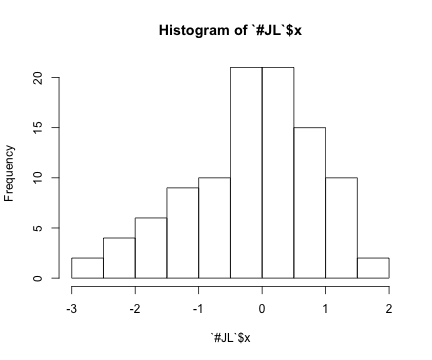

RObject{VecSxp}
$breaks
 [1] -3.0 -2.5 -2.0 -1.5 -1.0 -0.5  0.0  0.5  1.0  1.5  2.0

$counts
 [1]  2  4  6  9 10 21 21 15 10  2

$density
 [1] 0.04 0.08 0.12 0.18 0.20 0.42 0.42 0.30 0.20 0.04

$mids
 [1] -2.75 -2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75

$xname
[1] "`#JL`$x"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


In [34]:
using RCall

x = randn(100)

R"hist($x)"

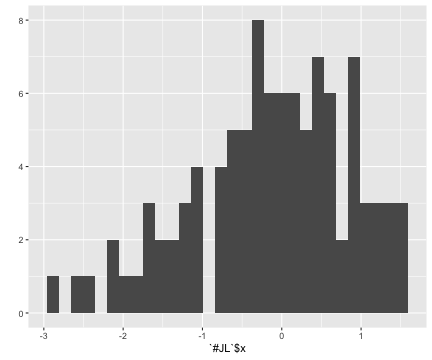

RObject{VecSxp}


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /Users/joshday/.julia/packages/RCall/Q4n8R/src/io.jl:110


In [35]:
R"library(ggplot2); qplot($x)"

## Python

In [36]:
using PyCall

@pyimport numpy.random as nr

nr.rand(3, 4)

3×4 Array{Float64,2}:
 0.211634  0.0867495  0.196341  0.292917
 0.418094  0.629202   0.430701  0.958753
 0.379004  0.701447   0.259894  0.548574

# REPL Modes

- Your first experience with Julia is probably through the REPL (read-eval-print-loop)

There are several **REPL Modes** that can be activated by certain characters:

- `?` (help)
- `]` (package manager)
- `;` (shell)
- `$` (R via [RCall.jl](https://github.com/JuliaInterop/RCall.jl))

# Linear Algebra

- **I could do multiple lectures on numerical linear algebra in Julia.  It's fantastic.**
- Call `BLAS` functions directly
- In-place (mutating) operations lead to huge performance gains!
- Types for storing matrix factorizations for quickly solving linear systems, etc.

In [37]:
using LinearAlgebra

In [38]:
x = randn(10, 2)

lu(x)

LU{Float64,Array{Float64,2}}
L factor:
10×2 Array{Float64,2}:
  1.0         0.0      
  0.500978    1.0      
  0.263843   -0.0334216
 -0.523558    0.0138241
  0.65308     0.724802 
 -0.933983   -0.46915  
 -0.0811935  -0.303485 
  0.462035    0.452718 
 -0.253607   -0.0825286
 -0.991092    0.264154 
U factor:
2×2 Array{Float64,2}:
 1.09787  -0.0892731
 0.0       1.91774  

In [39]:
c = cholesky(x'x)

Cholesky{Float64,Array{Float64,2}}
U factor:
2×2 UpperTriangular{Float64,Array{Float64,2}}:
 2.23928  1.12426
  ⋅       2.46813

In [40]:
inv(c)  # You very rarely need to do this

2×2 Array{Float64,2}:
  0.240805   -0.0824179
 -0.0824179   0.164159 

In [41]:
svd(x)

SVD{Float64,Float64,Array{Float64,2}}([0.414109 0.230481; 0.0278723 0.670208; … ; 0.0882143 0.087642; -0.626315 0.294388], [2.99356, 1.84624], [-0.537757 -0.8431; -0.8431 0.537757])

In [42]:
eigen(x'x)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
2-element Array{Float64,1}:
 3.4086171993283347
 8.961399619518117 
eigenvectors:
2×2 Array{Float64,2}:
 -0.8431    0.537757
  0.537757  0.8431  